This is a tutorial for basic use of abides_markets simulation.
It uses the simulator directly without the OpenAI Gym interface

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts
from abides_markets.configs import rmsc04

## Build runnable configuration

Here we are generating/building a config from the config file rmsc04. 
The config object is a dictionnary containing key elements like, start time, end time, agents to be used, latency and computation delay models.

In [2]:
config = rmsc04.build_config(seed=2, end_time="16:00:00")

In [3]:
config.keys()

dict_keys(['seed', 'start_time', 'stop_time', 'agents', 'agent_latency_model', 'default_computation_delay', 'custom_properties', 'random_state_kernel', 'stdout_log_level'])

## Running simulation

Once the config is ready it can be run using the abides runner function.
It instanciates a simulation kernel, runs the configuration and returns an end_state that mostly contains pointers to the different agent objects.
The agents are in their final state, their internal variables can be accessed to extract informations of interests like logs.

In [4]:
end_state = abides.run( config )

[3387088] INFO abides Simulation Start Time: 2024-09-07 19:35:40.008003


[3387088] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[3387088] INFO abides_core.kernel --- Simulation time: 2021-02-05 10:39:17, messages processed: 100,000, wallclock elapsed: 22.99s ---
[3387088] INFO abides_core.kernel --- Simulation time: 2021-02-05 11:50:45, messages processed: 200,000, wallclock elapsed: 50.90s ---
[3387088] INFO abides_core.kernel --- Simulation time: 2021-02-05 13:14:04, messages processed: 300,000, wallclock elapsed: 85.19s ---
[3387088] INFO abides_core.kernel --- Simulation time: 2021-02-05 14:34:04, messages processed: 400,000, wallclock elapsed: 121.01s ---
[3387088] INFO abides_core.kernel --- Simulation time: 2021-02-05 15:51:33, messages processed: 500,000, wallclock elapsed: 152.99s ---
[3387088] INFO abides_core.kernel Event Queue elapsed: 0:02:38.497402, messages: 511,913, messages per second: 3229.8
[3387088] INFO abides_core.kernel Mean ending value by agent type:
[3387088] 

Writing summary log


[3387088] INFO abides_core.kernel ValueAgent: 42555
[3387088] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: -87256
[3387088] INFO abides_core.kernel MomentumAgent: -352199
[3387088] INFO abides_core.kernel Simulation ending!
[3387088] INFO abides Simulation End Time: 2024-09-07 19:39:02.191207
[3387088] INFO abides Time taken to run simulation: 0:03:22.183204


## Retrieving results from end_state

By convention in abides_markets configuration the first agent is the exchange agent. 
It contains an order_book. By default it logs its history.

In [5]:
# end_state['agents'][0].order_status

In [6]:
order_book = end_state["agents"][0].order_books["ABM"]

### Order book history L1

L1 data snapshots for every tick can be extracted
( best bid and ask price and quantity )

In [7]:
L1 = order_book.get_L1_snapshots()

Here we plot the time series of the best bid and best ask price thoughout the simulation

In [8]:
for symbol in end_state["agents"][0].oracle.f_log:
    print(symbol)
    dfFund = pd.DataFrame(end_state["agents"][0].oracle.f_log[symbol])

ABM


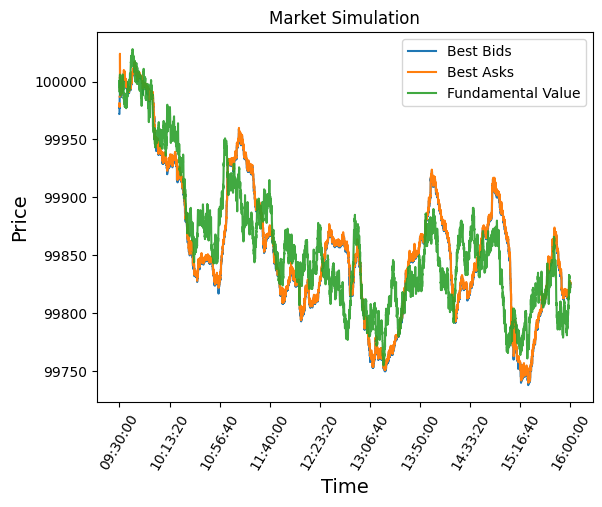

In [9]:
best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","qty"])
best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","qty"])

## All times are in ns from 1970, remove the date component to put them in ns from midnight
best_bids["time"] = best_bids["time"].apply( lambda x: x - ns_date(x) )
best_asks["time"] = best_asks["time"].apply( lambda x: x - ns_date(x) )
dfFund['time'] = dfFund['FundamentalTime'].apply( lambda x: x - ns_date(x))

plt.plot(best_bids.time,best_bids.price, label='Best Bids')
plt.plot(best_asks.time,best_asks.price, label='Best Asks')
plt.plot(dfFund.time, dfFund.FundamentalValue, alpha=0.9, label='Fundamental Value')
plt.ylabel('Price', size=14)
plt.xlabel('Time', size=14)
plt.title('Market Simulation')
plt.legend()
# band = 100
# plt.ylim(100_000-band,100_000+band)

time_mesh = np.linspace(
    str_to_ns("09:30:00"),
    str_to_ns("16:00:00"),
    10
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

### Order book history L2

L2 data snapshots for every tick can be extracted
( bids and asks price and quantity for every orderbook level. Here max depth logged is a parameter of the simulation and max number of levels we want to retrieve from the orderbook after the simulation is a parameter too)

In [10]:
# bids_array = best_bids.price.to_list()[1000:]
# asks_array = best_asks.price.to_list()[1000:]
# mid_array = [(x + y) / 2 for x, y in zip(bids_array, asks_array)]
# test_array = mid_array[:10_000:]

In [11]:
bids_array = best_bids.price.to_list()
asks_array = best_asks.price.to_list()

mid_array = []
for i in range(len(bids_array)):
    if bids_array[i] and asks_array[i]:

        mid_array.append((bids_array[i]+asks_array[i])/2)

print(len(mid_array))
print(len(mid_array)/(6.5*60*60))
test_array = mid_array[2000:-2000:5]
print(len(test_array))

66652
2.8483760683760684
12531


In [12]:
print(len(mid_array))
print(6.5*60*6)
69112/23400

66652
2340.0


2.9535042735042736

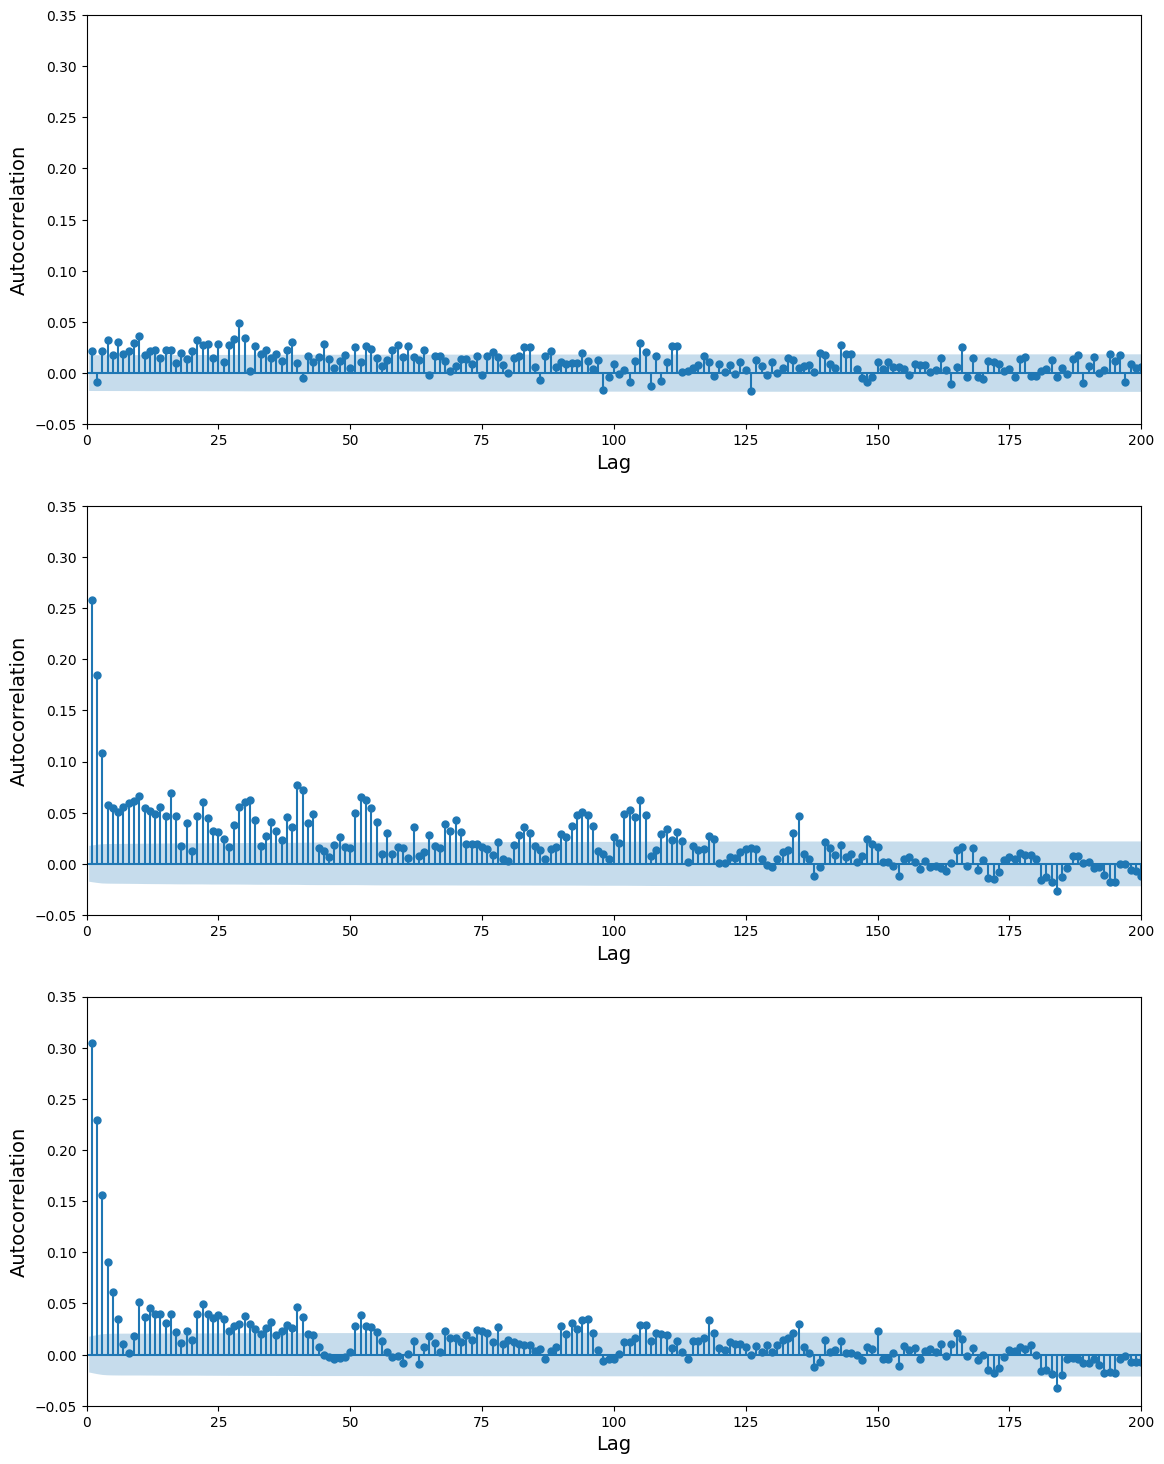

mean: -1.245840708165394e-07
std: 1.0025388089496152e-05


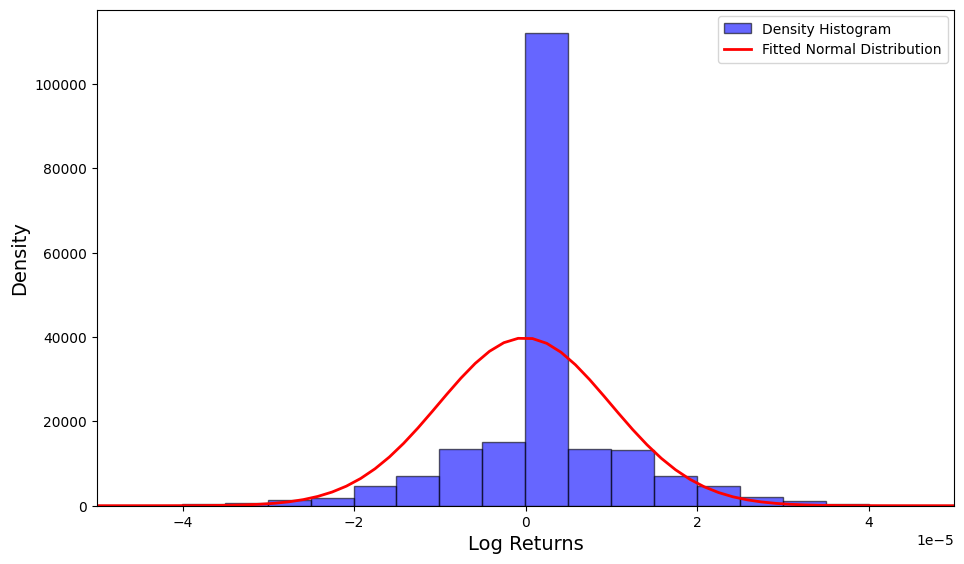

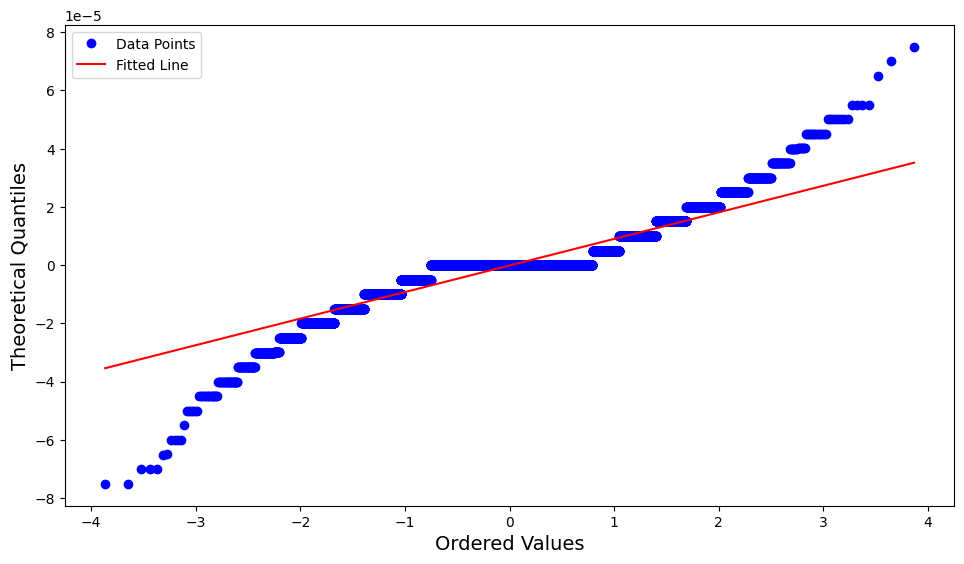

In [31]:
# Assuming financial_data is defined elsewhere in your code
financial_data = np.array(test_array)  # Replace with your actual financial data

# Calculate returns
returns = np.diff(np.log(financial_data))

# Calculate squared and absolute returns for analysis
squared_returns = returns ** 2
abs_returns = np.abs(returns)

# Adjusting plot configuration
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Define a function to plot the autocorrelations without lag 0
def plot_acf_exclude_zero(data, ax, title, lags=200,lower=-0.05,upper=0.35):
    plot_acf(data, ax=ax, lags=lags, alpha=0.05, zero=False)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Lag', fontsize=14)
    ax.set_ylabel('Autocorrelation', fontsize=14)
    ax.set_ylim(lower, upper)
    #ax.grid(True)
    ax.set_xlim(0, lags)  # Focus on the first half of lags to reduce empty space

# Plotting autocorrelations with adjusted y-axis limits and without lag 0
plot_acf_exclude_zero(returns, axes[0], '',lower=-0.05, upper=0.35)
plot_acf_exclude_zero(squared_returns, axes[1], '',lower=-0.05,upper=0.35)
plot_acf_exclude_zero(abs_returns, axes[2], '',lower=-0.05,upper=0.35)

plt.tight_layout(pad=2.0)  # Reducing padding to remove excess space
plt.show()

# Plotting distribution of returns with normal curve for comparison
plt.figure(figsize=(10, 6))
plt.hist(returns, density=True, bins=30, alpha=0.6, color='blue', edgecolor='black', label='Density Histogram')

# Plot the normal distribution with the same mean and standard deviation
mu, std = np.mean(returns), np.std(returns)
print('mean:', mu)
print('std:',std)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r-', linewidth=2, label='Fitted Normal Distribution')
plt.legend()

# Adding labels and title
plt.xlabel('Log Returns', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.title('Distribution of Returns with Normal Curve', fontsize=16)
#plt.ylim(0, plt.ylim()[1] * 0.85)  # Reduce the upper limit to remove excess space
plt.xlim(-5e-5,5e-5)
#plt.grid(True)
plt.tight_layout(pad=2.0)
plt.show()

# Plotting Q-Q plot
plt.figure(figsize=(10, 6))
res = probplot(returns, dist="norm", plot=plt)

# Manually add the legend for data points and fitted line
plt.plot([], [], 'o', label='Data Points', color='blue')  # Empty plot for the data points
plt.plot([], [], 'r-', label='Fitted Line')  # Empty plot for the fitted line

# Show the legend
plt.legend()

plt.xlabel('Ordered Values', fontsize=14)
plt.ylabel('Theoretical Quantiles', fontsize=14)
plt.title('')
plt.tight_layout(pad=2.0)
plt.show()
